# BlueShift Hackathon 2019

Hi Everyone! Thanks for coming! You can find all of the resources for our Hackathon in [this google folder](https://drive.google.com/open?id=1gxgpFDL093WpFB9K8VjKtvaQMUMA-CuI). This is also where you can upload final presentations or share files! If you'd like to download and run this notebook on your own computer, you can run the following in terminal: 

    git clone https://github.com/ysa2106/BlueShift_Hackathon_2019.git 
    

Here's a quick outline of this document: 

1. [Welcome to our Astro Hackathon](#welcome)
    - Potential project ideas 


2. [Example: Plotting Gaia Data of the Pleiades](#example) 
    - Step 1: downloading data
    - Step 2: opening and cleaning data
    - Step 3: pretty plots 
  
  
3. [Cheat Sheet](#cheat) (bits of code to open various file types)

In [55]:
#Here's a pretty standard list of import statements
#Make sure you have all these packages installed to run this notebook! 
#If you need help installing things see Yasmeen 
import matplotlib
import h5py
import astropy.io.fits as fits
import astropy.units as u
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from astropy.modeling.functional_models import Gaussian1D, Lorentz1D, Voigt1D
%matplotlib inline

#These lines are explained later in the 'Pretty Plots' section
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'Times New Roman'
rcparams['font.size'] = 16
matplotlib.rcParams.update(rcparams)

<a id='welcome'></a>
# Welcome! 

Welcome to the second annual BlueShift Astro Hackathon!

## What is a hackathon? 

Hackathon are generally weekend-long collaborative coding sprints. BlueShift's version is 10 hours where we work together to tackle some short, interesting astronomy projects. Hackathons are meant for coders of all levels, and it's a great oppurtunity to learn some coding for data analysis from you friends! No worries if you don't have much expereince, this event is meant to teach you! 

We will split up into groups of 2-5, and you all can decide what kind of project you want to tackle! Even though this is an astro hackathon, you are welcome to work on any project, astro related or not. 

## What kinds of projects can you work on? 

We really encourage that you and your teammates try to think of your own project! Have fun! Brainstorm! Think big!  If you are hitting a wall trying to think of something, here are some potential project ideas. You are welcome to take any one of them, but hopefully they inspire some other ideas in you:  
- Leapfrog Integrator 
    - Writing a function that calculates how two (or more) bodies interact in a given gravitational field
- Find and analyze a gravitational wave inspiral with data from the Gravitational Wave Open Science Center ([GWOSC](https://www.gw-openscience.org/about/))
- Animate fireworks??? 
    - Talk to Doug about this one! 

You can also check out [this really long list]() of potential project ideas that we came up with last year!

<a id='example'></a>
# Example: Plotting Gaia Data of the Pleiades

## Step 1: Download the Data

We are going to use ADQL to download Gaia data in the region of the Pleiades. **Skip this step by downloading [this data file](https://github.com/ysa2106/BlueShift_Hackathon_2019/blob/master/data/gaiadr2-pleadies-result.csv) from github.**

[Here](https://gea.esac.esa.int/archive/) is the webpage for Gaia's public data archive. We are going to download a subset of the data using the Astronomical Data Query Language (ADQL). Start by navigating to 'Search' then 'Advanced (ADQL)' to get to the right page. 

This screenshot should help you find the right page! 

![gaia_adql](imgs/gaia_archive_adql.png)

I've written a sample ADQL query to grab data near the Pleadies:

    SELECT ra, dec, parallax, parallax_over_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, pmra, pmdec
    FROM gaiadr2.gaia_source

    WHERE gaiadr2.gaia_source.parallax_over_error > 10
    AND gaiadr2.gaia_source.ra > 55
    AND gaiadr2.gaia_source.ra < 58
    AND gaiadr2.gaia_source.dec > 22
    AND gaiadr2.gaia_source.dec < 25
    
Let's deconstruct: 

The first command is `SELECT`, which allows us to specify which parameters we would like to download for each object. `ra` and `dec` are coordinates in the sky in units of degrees. `parallax` is the angular size of the displacement in the object's position when viewed from two different lines of sight in unites of milli-arcseconds, and `parallax_over_error` is just that value over the error in measurement. The next three parameters are the photometric magnitude of the source in three different passbands that Gaia measures. Specifically `phot_g_mean_mag` is green, `phot_bp_mean_mag` is blue, and `phot_rp_mean_mag` is red. You can read more about Gaia's passbands [here](https://www.cosmos.esa.int/web/gaia/iow_20180316). `pmra` and `pmdec` are the magnitudes of the object's proper motion along the two axis, and both are in units of milli-arcseconds per year. The next command is `FROM`, which allows us to specify which catalog / data release we would like to use. 

The next chunk of this code has a series of statements that put constraints on our download. Gaia observed over a billion sources, and if we just want to study the Pleiades there is no need to download that much data. The first cut that I make is a cut on data qaulity, by specifying that the `parallax_over_error` must be greater than 10. By restricting our download to objects with well-measured parallaxes, we can avoid downloading artifacts or poorly measured points that will contaminate our sample. The next four cuts I make specify a box on the sky around the `ra` and `dec` coordinates of the Pleiades. Since we are downloading all the objects in a couple square degrees on the sky, we are definitely going to download lots of things that are not actually in the Pleiades. So, the next step is going to be cleaning the data and downselecting to the stars we want! 

## Step 2: Open the data

In [4]:
#This first line reads a csv file and saves this data as a table
data = ascii.read("data/gaiadr2-pleadies-result.csv")  

In [5]:
#We can see this table by just calling the variable data
data

ra,dec,parallax,parallax_over_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
float64,float64,float64,float64,float64,float64,float64,float64,float64
56.0517402920591,24.972771121423662,1.77415610765104,12.766764,17.24436,18.341148,16.187065,13.574055234741136,-24.43283224852127
56.33840131968797,24.989985985804296,1.6792573907352004,54.941555,13.961323,14.430568,13.3330765,4.81041615760654,-15.521335368011599
56.40457265673144,24.82485757917893,1.1673835876743301,21.381489,15.433402,15.938289,14.762867,8.610720371066215,-7.468924357257893
56.43978978774277,24.98747475115385,0.7914034216096442,21.00776,11.352838,12.004973,10.602241,7.745107183381606,0.3060413594634857
56.12020449534123,24.747680350338648,3.7841111630169055,12.70351,17.943613,19.472027,16.616735,1.9972338571580202,-8.5418603285321
56.42839402974584,24.990009249574307,1.3061381502304064,46.79487,14.157352,14.643776,13.51663,4.4924627363790535,-13.658349319452956
56.110803130997446,24.808100424067643,2.6265606758159974,15.925248,17.880522,19.083054,16.693455,12.319659969919055,-24.199313795233284
56.50374140670497,24.977884750817815,2.553805398201038,36.902607,16.28908,17.274765,15.292551,-0.026321809353365477,11.366061548917935
56.454039613849446,24.9938785143629,0.9929556040954046,11.596006,16.919857,17.676968,16.055803,-3.110723892030975,-6.1622557854623246


In [6]:
#Let's define a bunch of arrays for each column on this table so it's easier to work with 

parallax = data['parallax'] #units: mas
ra = data['ra'] #units: deg
dec = data['dec'] #units: deg
prop_motion_ra = data['pmra'] #units: mas/yr
prop_motion_dec = data['pmdec'] #units: mas/yr
blue_pass = data['phot_bp_mean_mag']
red_pass = data['phot_rp_mean_mag']
apparent_mag = data['phot_g_mean_mag']

So let's start just by plotting all the data points we downloaded. You'll notice there is a pretty even distribution across the region we queried. This make sense, since Gaia observed billions of stars of many brightnesses all across the sky! One of the small clusters is probably the Pleiades! 

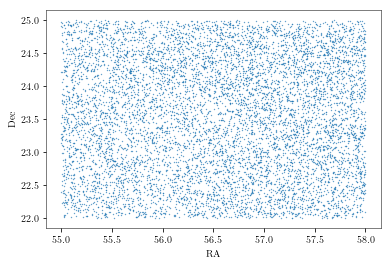

In [7]:
#Remember we imported matplotlib.pyplot as plt, so when we call plt here we are using that package
plt.scatter(ra, dec, s=0.1) #the scatter method allows us to make an easy scatter plot of (x, y)
plt.xlabel("RA") #These lines add axes labels
plt.ylabel("Dec")
plt.show() #This line lets us visualize the plot in this notebook 

Let's try plotting a Hertzsprung–Russell Diagram to see what types of stars Gaia observed. For an HR Diagram, we need to caluclate the color of each star 

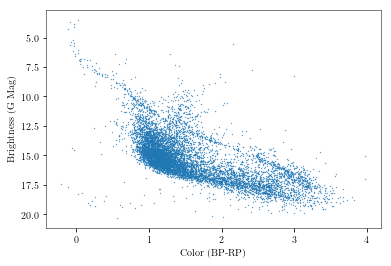

In [8]:
#Here we are subtracting two lists, and python interprets this as element-wise subtraction
#This means that for every element (every star) the blue-red value is calculated, then stored in a new list called color
color = blue_pass - red_pass

plt.scatter(color, apparent_mag, s=0.1)
plt.ylim(plt.ylim()[::-1]) #This line inverts the y axis, because lower magnitude values correspond to brighter stars which we want at the top of the diagram
plt.xlabel("Color (BP-RP)")
plt.ylabel("Brightness (G Mag)")
plt.show()

Yikes! That's messy! Since stars in the same cluster move together, let's try using proper motions to isolate the cluster members.

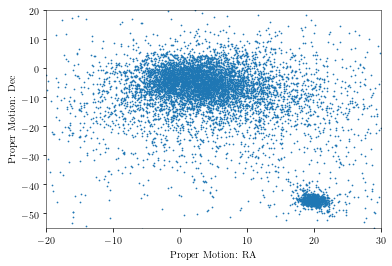

In [9]:
plt.scatter(prop_motion_ra, prop_motion_dec, s=0.5)
plt.xlim(-20,30) #These lines let us add limits to the plot. Try changing them and see how the plot changes 
plt.ylim(-55,20)
plt.xlabel("Proper Motion: RA")
plt.ylabel("Proper Motion: Dec")
plt.show()

Looks like the Pleiades members are clustered together around a `pmra` $\approx 20$ and a `pmdec` $\approx -50$. Lets make a cut around those values and plot the distances. We know that cluster members should all have around the same distance, so we can make an additional cut there. 

We can make approximate cuts on `pmra` and `pmdec` by eye, so I'm going to make cuts between right ascensions of 10 and 30 and declinations of -40 and -55. We are going to use a function called `where` from the `numpy` package (imported as `np`). `where` lets us find which elements in a list satisfy some condition, so here we are trying to find which elements in the RA and Dec lists are in the ranges specified.

In [10]:
#We can generate a list of indicies where the RA and Dec conditions are satisfied
index_ra_cut = np.where([i > 10 and i < 30 for i in prop_motion_ra])[0]
index_dec_cut = np.where([i < -40 and i > -55 for i in prop_motion_dec])[0]

#Since we have two lists, we want to grab all of the indicies that are in both lists
#These indicies correspond to all the points that are within both the RA range and the Dec range
#Note that sets don't preserve ordering or duplicates, but that doesn't matter for this case 
index_ra_dec_cut = list(set(index_ra_cut) & set(index_dec_cut))

In [11]:
#Now let's check how many stars are in our RA and Dec ranges 
len(index_ra_dec_cut)

850

In [12]:
#Now that we have a list of indicies, we can index all of our variables to downselect

parallax_cut = parallax[index_ra_dec_cut]
ra_cut = ra[index_ra_dec_cut]
dec_cut = dec[index_ra_dec_cut]
blue_pass_cut = blue_pass[index_ra_dec_cut]
red_pass_cut = red_pass[index_ra_dec_cut]
apparent_mag_cut = apparent_mag[index_ra_dec_cut]
prop_motion_ra_cut = prop_motion_ra[index_ra_dec_cut]
prop_motion_dec_cut = prop_motion_dec[index_ra_dec_cut]

So we downselected our sample to 800 stars in the range of proper motions that the Pleiades members seemed to have. Now, let's try downselecting based on the fact that all the cluster members should be the same distance away. First, let's try to get a sense of how large the cluster is so we can pick reasonable bounds on distance. According to a quick google search, the Pleiades is about 136 parsecs away and about 10 parsecs wide. Let's plot a histogram of the distances of our sample:

In [13]:
#Calculate the distance from parallax
distance = 1/(parallax_cut*0.001) #distance in parsecs, parallax in mas

<function matplotlib.pyplot.show(*args, **kw)>

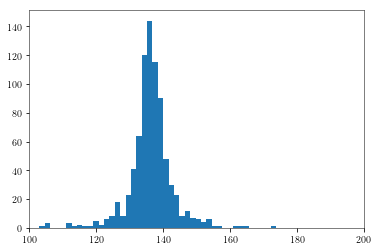

In [14]:
y, x, _ = plt.hist(distance, 800)
plt.xlim(100,200)
plt.show

In [15]:
#Let's find the peak of the graph:
max_idx = np.argmax(y)
peak = x[max_idx]
print("Peak at {}".format(peak))

Peak at 135.22035429433564


So it seems we've recovered roughly the right distance for the Pleiades! Let's downselect. I'll set the distance bounds by eye (knowing that we will have some contamination!)

In [16]:
index_dist_cut = np.where([i < 145 and i > 125 for i in distance])[0]

parallax_cut = parallax_cut[index_dist_cut]
ra_cut = ra_cut[index_dist_cut]
dec_cut = dec_cut[index_dist_cut]
blue_pass_cut = blue_pass_cut[index_dist_cut]
red_pass_cut = red_pass_cut[index_dist_cut]
apparent_mag_cut = apparent_mag_cut[index_dist_cut]
prop_motion_ra_cut = prop_motion_ra_cut[index_dist_cut]
prop_motion_dec_cut = prop_motion_dec_cut[index_dist_cut]

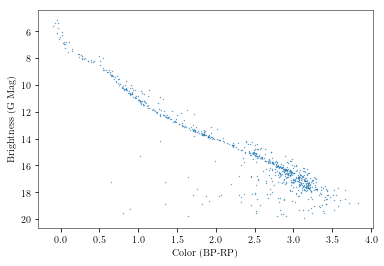

In [17]:
#Check how we did with an HR diagram: 
color_cut = blue_pass_cut - red_pass_cut

plt.scatter(color_cut, apparent_mag_cut, s=0.1)
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Color (BP-RP)")
plt.ylabel("Brightness (G Mag)")
plt.show()

Great! It looks like we've downselected with minimal contamination! Now its time to make that plot way more beautiful :-) 

## Step 3: Pretty Plots! 

In [18]:
#Didn't have time to finish this part!
#Let's do it together :-)

In [50]:
#I want to make the font bigger so im going to update the rcparams dictionary 
rcparams['font.size'] = 20
matplotlib.rcParams.update(rcparams)

In [60]:
#Calculate point density
xy_cut = np.vstack([color_cut,apparent_mag_cut])
z_cut = gaussian_kde(xy_cut)(xy_cut)

xy = np.vstack([color,apparent_mag])
z = gaussian_kde(xy)(xy)

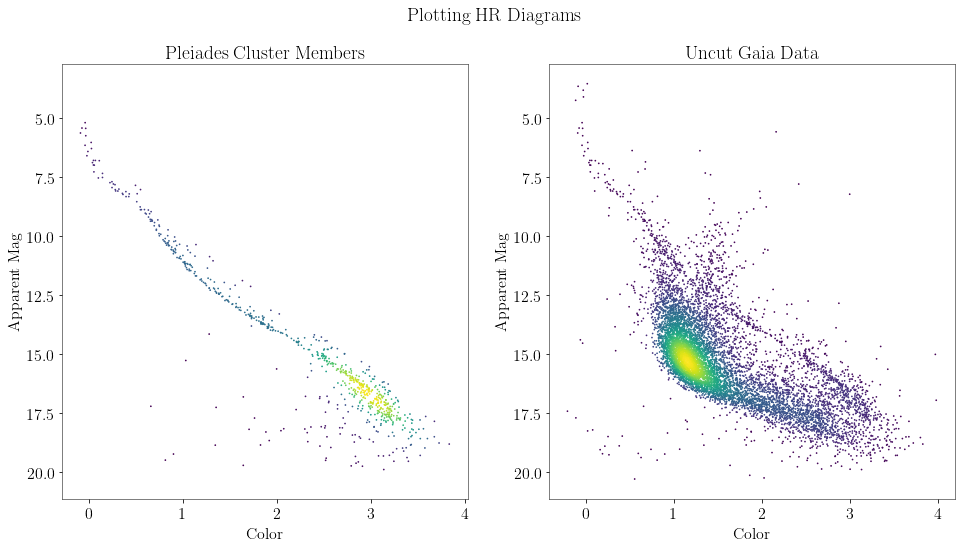

In [62]:
#we are going to first try plotting with subplots
#the command plt.subplots takes the arguements (number of rows, number of columns)
#figsize defines the size of the entire plot, 16 wide, 8 long
fig, axs = plt.subplots(1,2, figsize=(16,8))

fig.suptitle(r'Plotting HR Diagrams')

axs[0].scatter(color_cut, apparent_mag_cut, c=z_cut, s=0.5)
axs[0].set_title('Pleiades Cluster Members')
axs[1].scatter(color, apparent_mag, c=z, s=0.5)
axs[1].set_title('Uncut Gaia Data')

#This is one way to make changes to the limits of all your subplots, regardless of how many there are
for m, subplot in np.ndenumerate(axs):
    subplot.set_ylim(plt.ylim()[::-1])
    subplot.set_xlabel('Color')
    subplot.set_ylabel('Apparent Mag')
    

# Cheat Sheet: Common File Types 

Excuse the fact that I didn't have time to get sample files of each type!

You have to replace FILENAME with the the name of your file, or at the top of the code define it as a variable. For example: `FILENAME = 'my_file.txt'` 

## HDF5

In [ ]:
import h5py

file = h5py.File(FILENAME, 'r')

In [ ]:
list(file.keys()) #this will print out all the subfolders in your HDF5 file

In [ ]:
#If you want to access data in the first subfolder 
folder = list(file.keys())[0]
data = file[folder]

data.shape #will print the size and dimensions of the array 
data.dtype #will print out the type of data (ex: strings, integers)
data[0] #grabs the first element in your dataset

## FITS 

In [ ]:
from astropy.io import fits

file = fits.open(FILENAME, 'r')

In [ ]:
file.info() #will print out a summary of the contents of the file

In [ ]:
#FITS files have multiple HDU (Header Data Unit) objects
#The first one might have information on the data (it might be called PrimaryHDU)
#The others might be called ImageHDU, and have image data
header = file[0].header
header #will print out a description of the data in the object

In [ ]:
image = file[1].data #will grab the first image as a numpy array

## JSON 

In [ ]:
import json

with open(FILENAME, 'r') as json_file:
    data = json.load(json_file)
    data_some_value = data['some_key'] #JSON stores data with labels (keys), you can open it this way if you know the key

## Plain Text 

In [ ]:
file = open(FILENAME, 'r')
file.read() #prints the contents

In [ ]:
#If your file is newline delimited you can open it like this:
for line in file.readlines():
    print(line) 

In [ ]:
#If you want to make a list of strings of the first ten characters in each line you can do this: 
ten_char_per_line = []
for line in file.readlines():
    ten_char_per_line.append(line[0:10])

## CSV 

In [ ]:
import csv

with open(FILENAME, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',') #csv stands for Comma Seperated Values, but you can change the delimiter to spaces, tabs, etc
    for row in csv_reader:
        print(row)